In [1]:
%pip install gdown
import gdown

In [2]:
arquivo_destino_colab = "dataset.csv"
doc_id = "1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl"
URL = f"https://drive.google.com/uc?id={doc_id}"
gdown.download(URL, arquivo_destino_colab, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl
From (redirected): https://drive.google.com/uc?id=1u_OWAPkIdgJw1ah5xP_dGBFMSANxjxEl&confirm=t&uuid=1cb5e7d4-3a4d-4591-8d93-7edcaa84454b
To: /content/dataset.csv
100%|██████████| 151M/151M [00:03<00:00, 48.8MB/s]


'dataset.csv'

In [3]:
%pip install -q scikeras tensorflow imbalanced-learn


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
np.random.seed(42)
tf.random.set_seed(42)


In [5]:
df = pd.read_csv("dataset.csv")
candidatos = ["Class","class","Fraud","fraud","isFraud","target","Target","label","Label","fraude","y"]
alvo = None
for c in df.columns:
    if c in candidatos:
        alvo = c
        break
if alvo is None:
    bin_cols = []
    for c in df.columns:
        vals = pd.Series(df[c]).dropna().unique()
        if len(vals) <= 3:
            try:
                s = set(pd.Series(vals).astype(int).tolist())
                if s.issubset({0,1}):
                    bin_cols.append(c)
            except:
                pass
    alvo = bin_cols[0] if len(bin_cols) > 0 else df.columns[-1]
y = df[alvo].astype(int)
X = df.drop(columns=[alvo])
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, stratify=y.values if len(np.unique(y.values))>1 else None, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = {int(classes[i]): float(cw[i]) for i in range(len(classes))}


In [10]:
def build_model(n_hidden_layers=2, units=64, dropout=0.2, learning_rate=1e-3, l2_reg=0.0, optimizer="adam", meta=None, **kwargs):
    n_features = X_train.shape[1]
    if meta is not None:
        try:
            n_features = int(meta.get("n_features_in_", n_features))
        except Exception:
            pass
    model = Sequential()
    for i in range(int(n_hidden_layers)):
        if i == 0:
            model.add(Dense(int(units), activation="relu", kernel_regularizer=l2(l2_reg), input_dim=n_features))
        else:
            model.add(Dense(int(units), activation="relu", kernel_regularizer=l2(l2_reg)))
        if float(dropout) > 0:
            model.add(Dropout(float(dropout)))
    model.add(Dense(1, activation="sigmoid"))
    opt = tf.keras.optimizers.Adam(learning_rate=float(learning_rate)) if optimizer == "adam" else tf.keras.optimizers.RMSprop(learning_rate=float(learning_rate))
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])
    return model


In [11]:
baseline = build_model()
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = baseline.fit(X_train, y_train, epochs=40, batch_size=256, validation_split=0.2, callbacks=[es], class_weight=class_weight_dict, verbose=0)
y_prob_base = baseline.predict(X_test, verbose=0).ravel()
metrics_base = evaluate_model(y_test, y_prob_base, threshold=0.5)
cm_base = confusion_matrix(y_test, (y_prob_base>=0.5).astype(int))
cr_base = classification_report(y_test, (y_prob_base>=0.5).astype(int), digits=4)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
import random, itertools, numpy as np, pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

def fit_model_with_params(params):
    model = build_model(
        n_hidden_layers=params.get("n_hidden_layers", 2),
        units=params.get("units", 64),
        dropout=params.get("dropout", 0.2),
        learning_rate=params.get("learning_rate", 1e-3),
        l2_reg=params.get("l2_reg", 0.0),
        optimizer=params.get("optimizer", "adam"),
    )
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=int(params.get("epochs", 40)),
        batch_size=int(params.get("batch_size", 256)),
        validation_split=0.2,
        callbacks=[es],
        class_weight=class_weight_dict,
        verbose=0
    )
    val_auc = float(np.max(history.history.get("val_auc", [0.0])))
    y_prob = model.predict(X_test, verbose=0).ravel()
    mets = evaluate_model(y_test, y_prob, threshold=0.5)
    return {"model": model, "val_auc": val_auc, "y_prob": y_prob, "metrics": mets}

random.seed(42)
param_space = {
    "n_hidden_layers": [1, 2, 3, 4],
    "units": [32, 64, 128, 256],
    "dropout": [0.0, 0.2, 0.3, 0.5],
    "learning_rate": [1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
    "l2_reg": [0.0, 1e-5, 1e-4, 1e-3],
    "optimizer": ["adam", "rmsprop"],
    "epochs": [30, 50, 80],
    "batch_size": [128, 256, 512],
}

def sample_params(space):
    return {k: random.choice(v) for k, v in space.items()}

best_rnd_run = None
best_params_rnd = None
for i in range(20):
    params = sample_params(param_space)
    run = fit_model_with_params(params)
    if (best_rnd_run is None) or (run["val_auc"] > best_rnd_run["val_auc"]):
        best_rnd_run = run
        best_params_rnd = params

y_prob_rnd = best_rnd_run["y_prob"]
metrics_rnd = best_rnd_run["metrics"]
cm_rnd = confusion_matrix(y_test, (y_prob_rnd >= 0.5).astype(int))
cr_rnd = classification_report(y_test, (y_prob_rnd >= 0.5).astype(int), digits=4)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

In [16]:
import itertools

br = best_params_rnd

grid = {
    "n_hidden_layers": [br["n_hidden_layers"]],
    "units": [br["units"], min(256, max(32, br["units"]*2))],
    "dropout": [br["dropout"]],
    "learning_rate": [br["learning_rate"], min(1e-2, br["learning_rate"]*3)],
    "l2_reg": [br["l2_reg"]],
    "optimizer": [br["optimizer"]],
    "epochs": [br["epochs"]],
    "batch_size": [br["batch_size"]]
}

keys = list(grid.keys())
best_grd_run = None
best_params_grd = None
for values in itertools.product(*[grid[k] for k in keys]):
    params = dict(zip(keys, values))
    run = fit_model_with_params(params)
    if (best_grd_run is None) or (run["val_auc"] > best_grd_run["val_auc"]):
        best_grd_run = run
        best_params_grd = params

y_prob_grd = best_grd_run["y_prob"]
metrics_grd = best_grd_run["metrics"]
cm_grd = confusion_matrix(y_test, (y_prob_grd >= 0.5).astype(int))
cr_grd = classification_report(y_test, (y_prob_grd >= 0.5).astype(int), digits=4)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
results = pd.DataFrame(
    [
        [metrics_base["precision"], metrics_base["recall"], metrics_base["f1"], metrics_base["auc"]],
        [metrics_rnd["precision"], metrics_rnd["recall"], metrics_rnd["f1"], metrics_rnd["auc"]],
        [metrics_grd["precision"], metrics_grd["recall"], metrics_grd["f1"], metrics_grd["auc"]],
    ],
    columns=["precision","recall","f1","auc"],
    index=["baseline","random_search","grid_search"]
)
print(results)


               precision    recall        f1       auc
baseline        0.160813  0.887755  0.272300  0.975261
random_search   0.059500  0.897959  0.111604  0.986801
grid_search     0.055485  0.897959  0.104513  0.973254


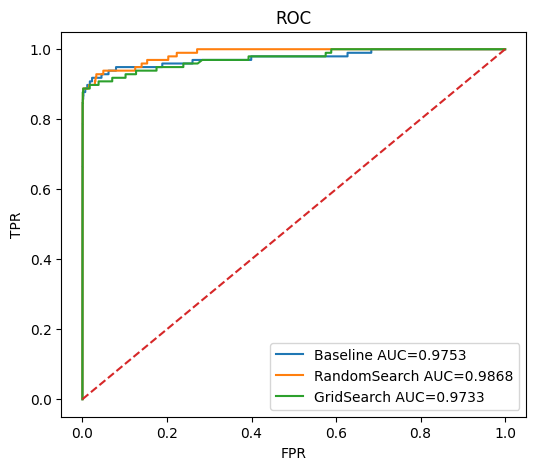

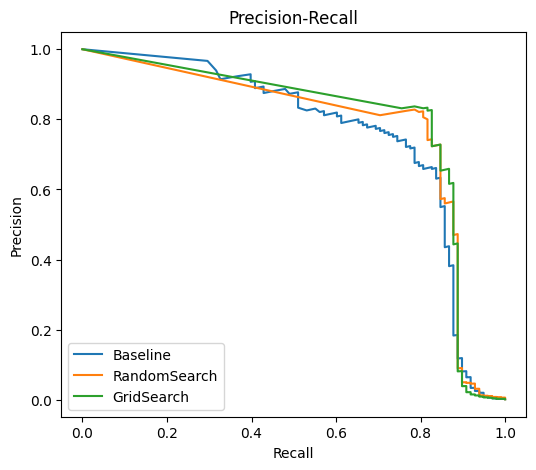

In [18]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

fpr_b, tpr_b, _ = roc_curve(y_test, y_prob_base)
fpr_r, tpr_r, _ = roc_curve(y_test, y_prob_rnd)
fpr_g, tpr_g, _ = roc_curve(y_test, y_prob_grd)

plt.figure(figsize=(6,5))
plt.plot(fpr_b, tpr_b, label=f"Baseline AUC={metrics_base['auc']:.4f}")
plt.plot(fpr_r, tpr_r, label=f"RandomSearch AUC={metrics_rnd['auc']:.4f}")
plt.plot(fpr_g, tpr_g, label=f"GridSearch AUC={metrics_grd['auc']:.4f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
plt.title("ROC")
plt.show()

pr_b, rc_b, _ = precision_recall_curve(y_test, y_prob_base)
pr_r, rc_r, _ = precision_recall_curve(y_test, y_prob_rnd)
pr_g, rc_g, _ = precision_recall_curve(y_test, y_prob_grd)

plt.figure(figsize=(6,5))
plt.plot(rc_b, pr_b, label="Baseline")
plt.plot(rc_r, pr_r, label="RandomSearch")
plt.plot(rc_g, pr_g, label="GridSearch")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.title("Precision-Recall")
plt.show()


In [19]:
import json

pd.DataFrame(cm_base, index=["Neg_True","Pos_True"], columns=["Neg_Pred","Pos_Pred"]).to_csv("confusion_matrix_baseline.csv", index=True)
pd.DataFrame(cm_rnd, index=["Neg_True","Pos_True"], columns=["Neg_Pred","Pos_Pred"]).to_csv("confusion_matrix_random_search.csv", index=True)
pd.DataFrame(cm_grd, index=["Neg_True","Pos_True"], columns=["Neg_Pred","Pos_Pred"]).to_csv("confusion_matrix_grid_search.csv", index=True)

open("classification_report_baseline.txt","w").write(cr_base)
open("classification_report_random_search.txt","w").write(cr_rnd)
open("classification_report_grid_search.txt","w").write(cr_grd)

results.to_csv("metrics_summary.csv", index=True)
json.dump(best_params_rnd, open("best_params_random_search.json","w"))
json.dump(best_params_grd, open("best_params_grid_search.json","w"))

summary_md = f"""
# Comparação de Modelos – Detecção de Fraude

## Métricas (teste)
{results.to_markdown()}

## Melhores Hiperparâmetros
- Random Search: {best_params_rnd}
- Grid Search: {best_params_grd}
"""
open("README_metrics.md","w").write(summary_md)


745